## **특징 선택**

모델링을 진행할 경우, features가 너무 적다면 정확도가 떨어집니다.
분류기준이 명확하지 않기 때문이죠.

그런데, 분류 기준이 너무 많아도 모델 성능이 떨어진다는 사실, 알고 계셨나요?

분류 기준이 과한 경우, 중요한 분류 기준 특징들만을 추출해 모델링을 하는 것이 도움이 될 수 있습니다. 

이때의 포인트는, 적당한 Features를 사용해야 한다는 것인데요,
너무 적지 않는 선에서, 모델이 과적합되지 않을 수 있도록 Feature를 선택하는 것이 좋습니다. 이때, 특정 K개의 Features를 선택해 모델링을 진행하여 최적 Feature개수를 추출하는 방법론이 바로 SelectKBest입니다.


오늘은 **SelectKBest를 활용해 Features의 개수를 추출하여, Best Ridge Regression 모델을 구성**해보도록 하겠습니다.

---



## **1. 데이터 전처리**

원핫인코딩을 수행할 수 있을 정도로만, 매우 간단히 전처리를 수행해보겠습니다.

In [1]:
# 필요한 Lib Import

import pandas as pd
from category_encoders import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV

ModuleNotFoundError: ignored

In [ ]:
# 데이터 Load
df = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/melbourne_house_prices/MELBOURNE_HOUSE_PRICES_LESS.csv')

# Cardinality가 높은 상위 4개 Features를 삭제
df.drop(columns=['Suburb','Address','SellerG','Date', 'CouncilArea'], inplace=True)

# 'Price'데이터에서, null값인 행 삭제
df.dropna(subset=['Price'], inplace=True)

# Duplicated rows 삭제
df.drop_duplicates(inplace=True)

# 데이터 확인
df=pd.DataFrame(df)
df

,Rooms,Type,Price,Method,Postcode,Regionname,Propertycount,Distance,CouncilArea
0,3,h,1490000.0,S,3067,Northern Metropolitan,4019,3.0,Yarra City Council
1,3,h,1220000.0,S,3067,Northern Metropolitan,4019,3.0,Yarra City Council
2,3,h,1420000.0,S,3067,Northern Metropolitan,4019,3.0,Yarra City Council
3,3,h,1515000.0,S,3040,Western Metropolitan,1543,7.5,Moonee Valley City Council
4,2,h,670000.0,S,3042,Western Metropolitan,3464,10.4,Moonee Valley City Council
...,...,...,...,...,...,...,...,...,...
63015,2,u,340000.0,SP,3199,South-Eastern Metropolitan,17055,38.0,Frankston City Council
63016,2,u,347700.0,SP,3199,South-Eastern Metropolitan,17055,38.0,Frankston City Council
63017,3,h,808000.0,S,3072,Northern Metropolitan,14577,8.4,Darebin City Council
63018,3,h,566000.0,S,3064,Northern Metropolitan,5833,20.6,Hume City Council


## **2. 원핫인코딩(One-Hot Encoding) 수행**

In [ ]:
encoder = OneHotEncoder(use_cat_names = True)
df_encoding = encoder.fit_transform(df)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
# 잘 수행되었는지 확인
df_encoding

,Rooms,Type_h,Type_t,Type_u,Price,Method_S,Method_SP,Method_VB,Method_PI,Method_SA,Postcode,Regionname_Northern Metropolitan,Regionname_Western Metropolitan,Regionname_Southern Metropolitan,Regionname_South-Eastern Metropolitan,Regionname_Eastern Metropolitan,Regionname_Northern Victoria,Regionname_Eastern Victoria,Regionname_Western Victoria,Propertycount,Distance
0,3,1,0,0,1490000.0,1,0,0,0,0,3067,1,0,0,0,0,0,0,0,4019,3.0
1,3,1,0,0,1220000.0,1,0,0,0,0,3067,1,0,0,0,0,0,0,0,4019,3.0
2,3,1,0,0,1420000.0,1,0,0,0,0,3067,1,0,0,0,0,0,0,0,4019,3.0
3,3,1,0,0,1515000.0,1,0,0,0,0,3040,0,1,0,0,0,0,0,0,1543,7.5
4,2,1,0,0,670000.0,1,0,0,0,0,3042,0,1,0,0,0,0,0,0,3464,10.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63015,2,0,0,1,340000.0,0,1,0,0,0,3199,0,0,0,1,0,0,0,0,17055,38.0
63016,2,0,0,1,347700.0,0,1,0,0,0,3199,0,0,0,1,0,0,0,0,17055,38.0
63017,3,1,0,0,808000.0,1,0,0,0,0,3072,1,0,0,0,0,0,0,0,14577,8.4
63018,3,1,0,0,566000.0,1,0,0,0,0,3064,1,0,0,0,0,0,0,0,5833,20.6


### **3. 데이터를 train/test 셋으로 무작위 분할(80:20)**

In [ ]:
X =df_encoding.drop(['Price'],axis=1)
y = df_encoding['Price']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### **4. Feature Selection 수행 (SelectKBest 사용, k = 20)**

In [ ]:
selector = SelectKBest(score_func=f_regression, k=20)

X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# SelectKBest 수행 후 shape 확인
X_train_selected.shape, X_test_selected.shape

((34012, 20), (8503, 20))

In [ ]:
# Select 된 Columns값, 그렇지 않은 Columns값 추출

all_names = X_train.columns
selected_mask = selector.get_support()

selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask] 

### **5. LinearRegression 적용했을 때, Select K값 별 회귀 평가지표값 산출, 최적 Features값 도출**

1 features
Selected names:  Index(['Rooms'], dtype='object')
Test MAE: $382,454
Test R2: 0.1713455207640796 

2 features
Selected names:  Index(['Rooms', 'Regionname_Southern Metropolitan'], dtype='object')
Test MAE: $346,618
Test R2: 0.3413352238500944 

3 features
Selected names:  Index(['Rooms', 'Type_u', 'Regionname_Southern Metropolitan'], dtype='object')
Test MAE: $341,179
Test R2: 0.3714387896186431 

4 features
Selected names:  Index(['Rooms', 'Type_h', 'Type_u', 'Regionname_Southern Metropolitan'], dtype='object')
Test MAE: $340,359
Test R2: 0.37881903196958 

5 features
Selected names:  Index(['Rooms', 'Type_h', 'Type_u', 'Regionname_Southern Metropolitan',
       'Distance'],
      dtype='object')
Test MAE: $307,135
Test R2: 0.47066109274755896 

6 features
Selected names:  Index(['Rooms', 'Type_h', 'Type_u', 'Regionname_Northern Metropolitan',
       'Regionname_Southern Metropolitan', 'Distance'],
      dtype='object')
Test MAE: $304,377
Test R2: 0.4750940350280959 

7 fea

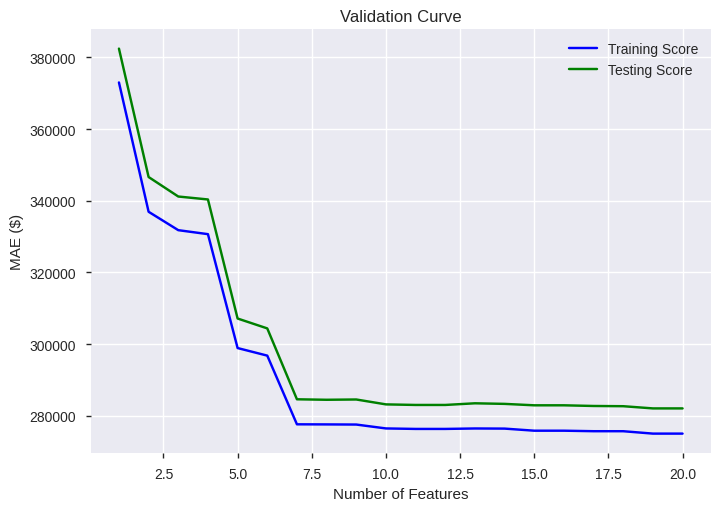

In [ ]:
training = []
testing = []
ks = range(1, len(X_train.columns)+1)

for k in range(1, len(X_train.columns)+ 1):
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    all_names = X_train.columns
    selected_mask = selector.get_support()
    selected_names = all_names[selected_mask]
    print('Selected names: ', selected_names)

    
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_train_selected)
    mae = mean_absolute_error(y_train, y_pred)
    training.append(mae)
    
    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    testing.append(mae)
    print(f'Test MAE: ${mae:,.0f}')
    print(f'Test R2: {r2} \n')

plt.plot(ks, training, label='Training Score', color='b')
plt.plot(ks, testing, label='Testing Score', color='g')
plt.ylabel("MAE ($)")
plt.xlabel("Number of Features")
plt.title('Validation Curve')
plt.legend()
plt.show()

**결론**: 12 Features 산출 시 최적 값 도출. (그보다 많은 경우보다 Val Curve의 차이도 크지 않으므로 12개로 지정)

Selected names:  Index(['Rooms', 'Type_h', 'Type_u', 'Method_SP', 'Method_VB',
       'Regionname_Northern Metropolitan', 'Regionname_Western Metropolitan',
       'Regionname_Southern Metropolitan',
       'Regionname_South-Eastern Metropolitan', 'Regionname_Northern Victoria',
       'Regionname_Western Victoria', 'Distance'],
      dtype='object')
Test MAE: $282,820
Test R2: 0.5107460063617557 

### **6. 선택한 Features 사용해 Best Ridge Regression 모델링**


In [ ]:
bestreg = dff[['Rooms', 'Type_h', 'Type_u', 'Method_SP', 'Method_VB',
       'Regionname_Northern Metropolitan', 'Regionname_Western Metropolitan',
       'Regionname_Southern Metropolitan',
       'Regionname_South-Eastern Metropolitan', 'Regionname_Northern Victoria',
       'Regionname_Western Victoria', 'Distance','Price']]

X = bestreg.drop(['Price'],axis=1)
y = bestreg['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# scikit-learn 업그레이드
!pip install --upgrade scikit-learn

In [ ]:
# RidgeCV 실행, 하이퍼파라미터값: alphas

alphas = [0.01, 0.05, 0.1, 0.2, 1.0, 10.0, 100.0]

ridge = RidgeCV(alphas=alphas, normalize=True, cv=3)
ridge.fit(X, y)

print("alpha: ", ridge.alpha_)

결론: 최적 alphas값은 0.01

### **6. 최적 하이퍼파라미터 적용 후 Ridge Regression 모델링**

In [ ]:
model = Ridge(alpha=ridge.alpha_, normalize=True)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=True, random_state=None, solver='auto', tol=0.001)

In [ ]:
pd.DataFrame(y_pred)

,0
0,8.394072e+05
1,9.921947e+05
2,1.057827e+06
3,6.099836e+05
4,8.741980e+05
...,...
8498,1.322865e+06
8499,1.039290e+06
8500,7.803010e+05
8501,8.163911e+05


In [ ]:
# 회귀모델 평가지표로 MAE 선택, MAE값 확인
mae = mean_absolute_error(y_test, y_pred)
mae

551605.7870678687